In [2]:
import json
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import ternary
%matplotlib inline

from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier

In [3]:
# Class to store each tag coordinate data
class tagClass:
    def __init__(self, data: dict, tClass):
        self.x = data.get("x")
        self.y = data.get("y")
        self.fn = data.get("fn").removeprefix("40data/")
        self.label = data.get("label")
        self.tagX, self.tagX2, self.tagY, self.tagY2 = self.getSnip()
        self.tagClass = tClass
    
    def getX(self):
        return self.x
    def getY(self):
        return self.y
    def getFn(self):
        return self.fn
    def getLabel(self):
        return self.label
    def getFileClass(self):
        return tagClass
    
    def getSnip(self):
        s = 16
        newX = self.x-(s/2)
        if newX%2 != 0:
            newX -= 1
        newY = self.y-(s/2)
        if newY%2 != 0:
            newY -= 1
        return int(newX), int(newX+s), int(newY), int(newY+s)
    
    def getSnipCoords(self):
        return self.tagX, self.tagX2, self.tagY, self.tagY2

In [4]:
raw15 = json.load(open("leon_bee_photos_3rdMarch2023/bee_track40_15m.json"))

In [5]:
def getTags(rawData, nType):
    listData = []
    for n in nType:
        for i in rawData[n]:
            i = dict(i)
            d = tagClass(i, n)
            listData.append(d)
    return listData

In [6]:
trainTags = getTags(raw15['0'], ['649', '655', '657', '659', '661'])
testTags = getTags(raw15['0'], ['669', '671'])

In [7]:
bayerFilter = [["R", "G"],
               ["G", "B"]]
# Find Bayer filter pixel colour for given coordinate
def getBayer(x, y):
    if x%2 == 0:
        if y%2 == 0:
            return "R" #RGGB
        else:
            return "G" #GBRG
    else:
        if y%2 == 0:
            return "G" #GRBG
        else:
            return "B" #BGGR

In [8]:
def getSnipPlot(tag):
    tagX, tagX2, tagY, tagY2 = tag.getSnipCoords()
    filename = "leon_bee_photos_3rdMarch2023/cam5/"+tag.getFn()
    file = np.load(filename, allow_pickle=True)
    # print(filename)
    photo = file['img']
    # plt.imshow(photo[tagY:tagY2,tagX:tagX2],cmap='gray')
    # plt.colorbar()
    # rect = patches.Rectangle((tag.getY()-tagY-5, tag.getX()-tagX-5), 10, 10, linewidth=1, edgecolor='r', facecolor='none')
    # plt.gca().add_patch(rect)
    # plt.show()

    return photo[tagY:tagY2,tagX:tagX2].astype(np.float32)

In [9]:
def getPhoto(tag: tagClass):
    filename = "leon_bee_photos_3rdMarch2023/cam5/"+tag.getFn()
    file = np.load(filename, allow_pickle=True)
    photo = file['img']
    return photo

In [10]:
def getPixels(t: tuple, photo):
    tagX, tagX2, tagY, tagY2 = t
    red = 0
    green = 0
    blue = 0
    for px in range(tagX, tagX2):
        for py in range(tagY, tagY2):
            col = getBayer(py, px)
            if col == 'R':
                red += int(photo[py, px])
            elif col == 'G':
                green += int(photo[py, px])
            else:
                blue += int(photo[py, px])
    totalSum = red + green + blue
    return red/totalSum, green/totalSum, blue/totalSum

In [11]:
xTags = pd.DataFrame(columns=["Label", "Red", "Green", "Blue", "Tag"])
for tag in trainTags:
    photo = getPhoto(tag)
    redVal, greenVal, blueVal = getPixels(tag.getSnipCoords(), photo)
    xTags.loc[len(xTags.index)] = [int(tag.getLabel().removeprefix("gridTag")), redVal, greenVal, blueVal, tag]
# xTrain, xTest, yTrain, yTest = train_test_split(xTags[["Red", "Green", "Blue"]], xTags["Label"], test_size=0.2)

In [12]:
yTags = pd.DataFrame(columns=["Label", "Red", "Green", "Blue", "Tag"])
for tag in testTags:
    photo = getPhoto(tag)
    redVal, greenVal, blueVal = getPixels(tag.getSnipCoords(), photo)
    yTags.loc[len(yTags.index)] = [int(tag.getLabel().removeprefix("gridTag")), redVal, greenVal, blueVal, tag]

In [13]:
allTags = pd.concat([xTags, yTags])

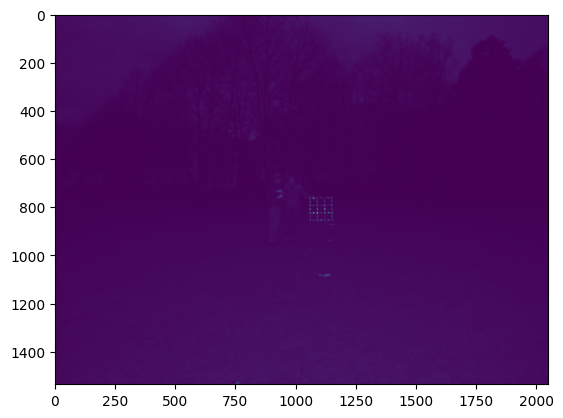

In [14]:
plt.imshow(getPhoto(xTags['Tag'][0]))

In [15]:
getSnipPlot(xTags["Tag"][0])

array([[ 11.,   2.,  12.,   3.,  14.,   3.,  13.,   3.,  12.,   2.,  12.,
          3.,  12.,   2.,  12.,   3.],
       [  2.,   4.,   3.,   4.,   3.,   4.,   3.,   4.,   3.,   4.,   3.,
          4.,   2.,   3.,   2.,   4.],
       [ 11.,   3.,  12.,   3.,  13.,   3.,  12.,   3.,  11.,   3.,  11.,
          2.,  11.,   2.,  10.,   2.],
       [  2.,   3.,   3.,   5.,   3.,   4.,   3.,   4.,   2.,   3.,   3.,
          5.,   3.,   4.,   3.,   3.],
       [ 11.,   3.,  12.,   3.,  11.,   3.,  11.,   4.,  15.,   4.,  12.,
          3.,  11.,   3.,   9.,   3.],
       [  2.,   4.,   3.,   5.,   3.,   4.,   3.,  17.,   9.,  21.,   7.,
          7.,   5.,   6.,   5.,   8.],
       [  8.,   2.,  10.,   2.,  11.,   3.,  20.,  16.,  83.,  26.,  54.,
         11.,  19.,   8.,  16.,  10.],
       [  2.,   3.,   2.,   4.,   3.,  10.,  13.,  57.,  27.,  65.,  28.,
         26.,  10.,  12.,   9.,  14.],
       [  8.,   2.,  10.,   2.,   9.,   5.,  37.,  28., 102.,  36., 102.,
         22.,  24.,  1

## Plot to RGB heatmap

In [16]:
def colorPoint(x, y, z, scale):
    b = x/scale
    g = y/scale
    r = z/scale
    return (r, g, b, 1.)

def generateHeatmapData(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = colorPoint(i, j, k, scale)
    return d

def plotHeatmap(asTuples, labels, scale):
    data = generateHeatmapData(scale)
    plt.figure(figsize=[12,10])
    ax = plt.gca()
    _, tax = ternary.figure(ax,scale=scale)

    tax.scatter(asTuples*scale, marker='x', color='#fff', label=labels, zorder=3)#np.array(expected['002']))
    tax._redraw_labels()
    tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False)
    tax._redraw_labels()
    # Remove default Matplotlib Axes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    tax.boundary()
    tax.set_title("RGBA Heatmap")
    for a, b in zip(labels, asTuples):
        tax.annotate(int(a), b, color='white')
    plt.show()

In [17]:
scale = 30
# tagList = [0]
# sampleTags = allTags.loc[allTags["Label"].isin(tagList)]
# asTuples = [[x.iloc[1]*scale, x.iloc[2]*scale, x.iloc[3]*scale] for index, x in sampleTags.iterrows()]
# labels = sampleTags["Label"]
# plotHeatmap(asTuples, labels, scale)

C:\Users\katie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


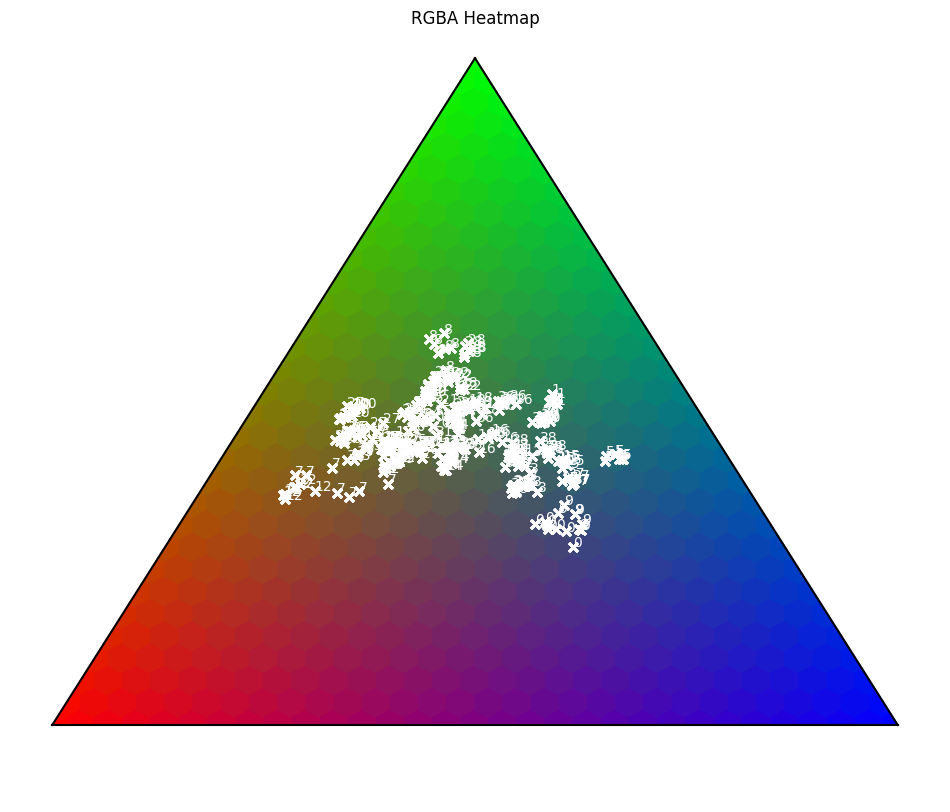

In [18]:
asTuples = [[x.iloc[1]*scale, x.iloc[2]*scale, x.iloc[3]*scale] for index, x in allTags.iterrows()]
labels = allTags["Label"]
plotHeatmap(asTuples, labels, scale)

## ML train/test

In [ ]:
# gnb = GaussianNB().fit(xTrain, yTrain)
# gnbPred = gnb.predict(yTags[["Red", "Green", "Blue"]])
# clf = svm.SVC().fit(xTrain, yTrain)
# svmPred = clf.predict(yTags[["Red", "Green", "Blue"]])
# mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5, 2), random_state=1).fit(xTrain, yTrain)
# mlpPred = mlp.predict(yTags[["Red", "Green"]])

In [22]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_squared_error
def scores(modelPred, name):
    print(name)
    print("Accuracy: ", accuracy_score(yTags["Label"], modelPred))
    print("F1: ", f1_score(yTags["Label"], modelPred, average='macro'))
    print("Precision: ", precision_score(yTags["Label"], modelPred, average='macro', zero_division=np.nan))
    print("Recall: ", recall_score(yTags["Label"], modelPred, average='macro'))
    print("MSE: ", mean_squared_error(yTags["Label"], modelPred), "\n")

In [23]:
# scores(gnbPred, "GNB")
# scores(svmPred, "SVM")
# scores(mlpPred, "MLP")

## Random notes/old code

In [24]:
# average colours from all images - normalise
# R/(R+G+B) G/(R+G+B)
# train model on colours & labels
# test model to classfiy other image labels

# maybe remove background mesh
# func pixel coords generated to show brightness
# psf tagxy brightness pf col, bg of col, pixel ->> pred cixel col -> SSE
# brightness for each col -> then loop all pixels then predict pixels -> SSE = func - true picel val

In [25]:
# run with smaller box around pixels - brightest as centre?
# bokeh out of focus width affected by distance?
# estimate brightness of bg?
# estimate width of brightest tags
# hexagonal bokeh - find centre of bokeh
# px, py, bi, hi, xi, yi per picture but width is same
# x y is centre of bokeh - tag coords
# 
# sum ( fn(px py xi yi hi w) - true px py ) ^2 ) for each pixel -> fn = guess pixel value
# sum that for all pictures - see notebook!!

In [26]:
# initial_parameters = np.array([
#     np.random.rand()*realImg.shape[0],
#     np.random.rand()*realImg.shape[1], # tag location
#     np.random.rand()*np.max(realImg), # intensity r
#     np.random.rand()*np.max(realImg), # intensity g
#     np.random.rand()*np.max(realImg), # intensity b
#     np.random.rand()*np.min(realImg), # background r
#     np.random.rand()*np.min(realImg), # background g
#     np.random.rand()*np.min(realImg) # background b
# ])

# initial_parameters = np.array([8,9,100,100,100,0,0,0])
# res = minimize(cost_function, initial_parameters, args = (3, realImg))#, method= 'Nelder-Mead', bounds=[(6,10),(7,11),(0,255),(0,255),(0,255),(0,30),(0,30),(0,30)])
# tag loc = middle (width/2), bg = 0,  intensity = largest val in pic method='Nelder-Mead',
# res.message

In [27]:
# params_test = [8, 6.5, 100, 100, 100, 0, 0, 0]
# print(cost_function(params_test, 3, realImg))
# tagCoord = [params_test[0], params_test[1]]
# tagBright = [params_test[2], params_test[3], params_test[4]]
# bgBright = [params_test[5], params_test[6], params_test[7]]

# pixel_value_guesses = simulate_image(tagCoord, tagBright, bgBright, 3, realImg.shape)
# plt.imshow(np.array(pixel_value_guesses).reshape(16,16),cmap='gray')
# plt.colorbar()

# plt.imshow(np.array(pixel_value_guesses).reshape(16,16),cmap='gray')
# plt.colorbar()
# plt.figure()
# plt.imshow(realImg,cmap='gray')
# plt.colorbar()

In [28]:
# bestScore = np.inf
# best = None
# for restart in range(100):
#     initial_parameters = np.array([
#         (0.3+0.4*np.random.rand())*realImg.shape[0],
#         (0.3+0.4*np.random.rand())*realImg.shape[1], # tag location
#         0.2+0.8*np.random.rand()*np.max(realImg), # intensity r
#         0.2+0.8*np.random.rand()*np.max(realImg), # intensity g
#         0.2+0.8*np.random.rand()*np.max(realImg), # intensity b
#         0.05*np.random.rand()*np.min(realImg), # background r
#         0.05*np.random.rand()*np.min(realImg), # background g
#         0.05*np.random.rand()*np.min(realImg) # background b
#     ])
#     # res = minimize(cost_function, initial_parameters, args = (3, realImg), method= 'SLSQP', bounds=[(6,10),(6,10),(0,255),(0,255),(0,255),(0,30),(0,30),(0,30)])
#     res = minimize(cost_function, initial_parameters, args = (3, realImg), method= 'Powell', bounds=[(6,10),(6,10),(0,255),(0,255),(0,255),(0,30),(0,30),(0,30)])
#     if res.fun < bestScore:
#         bestScore = res.fun
#         best = res
# res = best
# print(res)

In [29]:
# tag_loc = res.x[:2] # tag location
# intensity = res.x[2:5] # intensity rgb
# background = res.x[5:] # background rgb
# tag_loc, intensity, background
# guess = simulate_image(tag_loc, intensity, background, 3, realImg.shape)
# plt.plot(realImg)
# plt.plot(guess)
# wsamps = np.random.multivariate_normal(res.x, res.hess_inv, 100)

# for w in wsamps:
#     tag_loc, intensity, background = [w[0], w[1]], [w[2], w[3], w[4]], [w[5], w[6], w[7]]
#     guess = simulate_image(tag_loc, intensity, background, 3, realImg.shape)
#     plt.plot(guess, 'k-', alpha=0.1) 

## Cost function

In [30]:
def simulate_pixel(pixelCoord, tagCoord, tagBrightness, bgBrightness, psfWidth):
    # dist = math.dist(tagCoord, pixelCoord)
    dist = np.sqrt(np.sum((tagCoord - pixelCoord)**2))
    if dist>psfWidth+0.5:
           return bgBrightness
    elif dist<psfWidth-0.5:
        return tagBrightness
    else:
       return (bgBrightness*(0.5 + dist - psfWidth)-tagBrightness*(dist - psfWidth - 0.5))
# dist>w+0.5 -> bg
# dist<w-0.5 -> tag
# bg*(0.5 + dist - w)- tag*(dist - w - 0.5) ### check func for linear transition between bg and tag

#hessian = second derivative -> hess_inv shows variance of gaussian spread
# mcmc for distribution sampling

def simulate_pixel_gaussian(pixelCoord, tagCoord, tagBrightness, bgBrightness, psfWidth):
    dist = np.sqrt(np.sum(tagCoord - pixelCoord)**2)
    return tagBrightness * np.exp(-(dist**2)/(psfWidth**2)) + bgBrightness #NEED TO NORMALISE!

# def simulate_image(tagCoord, [tagBright_r, tagBright_g, tagBright_b], [bgBright_r, bgBright_g, bgBright_b], psfWidth, trueImg):
def simulate_image(tagCoord, t, b, psfWidth, imgShape):
    pixel_value_guesses = []

    # loop over pixel coords for each colour...

    for pixX in range(imgShape[0]):
        for pixY in range(imgShape[1]):
            # get colour based on bayer
            colour = pixX % 2 + pixY % 2
            # call simulate_pixel with the coords of the pixel and the appropriate element from the rgb vectors...etc
            pixel_value_guesses.append(simulate_pixel([pixX, pixY], tagCoord, t[colour], b[colour], psfWidth))
    return np.array(pixel_value_guesses).astype(np.float32)


def cost_function(params, psfWidth, trueImg):
    tagCoord = params[:2]
    tagBright = params[2:5]
    bgBright = params[5:]
    pixel_value_guesses = simulate_image(tagCoord, tagBright, bgBright, psfWidth, trueImg.shape)
    # sum square error over all the pxiels between the true image and the simulate_image
    square_error = np.sum([(s - a)**2 for (s, a) in zip(pixel_value_guesses, trueImg.flatten())])
    return square_error

In [31]:
np.set_printoptions(precision=2, suppress=True)

In [32]:
realImg = getSnipPlot(allTags['Tag'].iloc[0]) # clip this photo per tag
cost_function(np.array([0, 0, 12, 14, 5, 4, 6, 5]), 3, realImg)

np.float32(69445.91)

In [33]:
params = np.array([8.0, 8, 100, 50, 20, 5, 4, 3])

In [50]:
import autograd.numpy as np
from autograd import grad, hessian

def temp(p):
  return cost_function(p, 2.4, realImg)
grad(temp)(params)

array([ 14629.78, -38253.69,    244.08,    395.68,   -226.  ,   -899.68,
            0.97,   -606.  ])

In [51]:
res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
               bounds=((0,16), (0,16), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None)))

C:\Users\katie\AppData\Local\Temp\ipykernel_8728\2860797999.py:1: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),


In [53]:
grad(temp)(res.x)

array([-0.62, -2.09, -0.01, -0.2 , -0.03,  0.15, -0.4 , -0.07])

In [54]:
hess = hessian(temp)(res.x)
[print("%0.5f" % a) for a in np.diag(hess)]

52861.30710
47278.01714
7.75006
15.73313
7.78279
117.13674
235.72399
117.38170


[None, None, None, None, None, None, None, None]

In [55]:
ci = np.sqrt(np.diag(np.linalg.inv(hess)))*1.96
names = ['x', 'y', 'r', 'g', 'b', 'bg_r', 'bg_g', 'bg_b']
[print("%7s: %0.5f-%0.5f" % (n, a, b)) for n, a, b in zip(names, res.x-ci, res.x+ci)]

      x: 7.64336-7.66079
      y: 9.37917-9.39771
      r: 97.75624-99.17152
      g: 28.46487-29.45867
      b: 63.61798-65.03443
   bg_r: 10.83601-11.20016
   bg_g: 3.91408-4.16973
   bg_b: 6.21604-6.57967


[None, None, None, None, None, None, None, None]

### Compare reconstructions across multiple images for one tag

In [57]:
def getOnlyColour(c, guess, values):
    singleColour = np.zeros_like(values)
    singleColourReal = np.zeros_like(values)
    for x in range(values.shape[0]):
        for y in range(values.shape[1]):
            if getBayer(x, y) == c:
                singleColour[x, y] = guess[x, y]
                singleColourReal[x, y] = values[x, y]
            else:
                singleColour[x, y] = 0
                singleColourReal[x, y] = 0
    return singleColour, singleColourReal

In [148]:
onlyTag0 = allTags.loc[allTags['Label']==0]
onlyTag0.reset_index(inplace=True)

C:\Users\katie\AppData\Local\Temp\ipykernel_8728\3783360735.py:7: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),


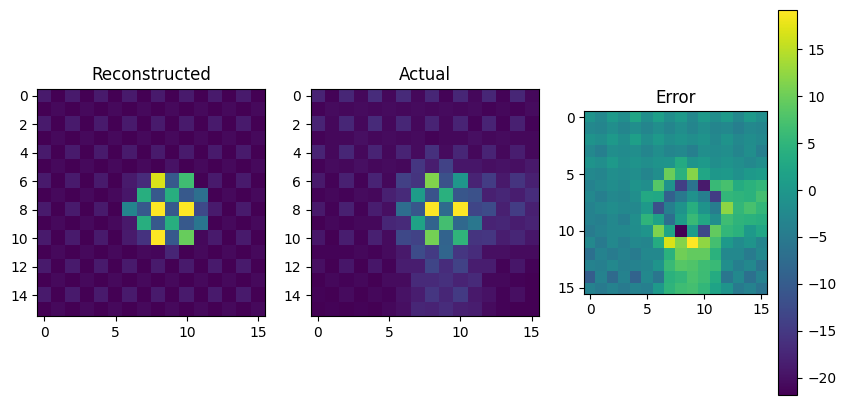

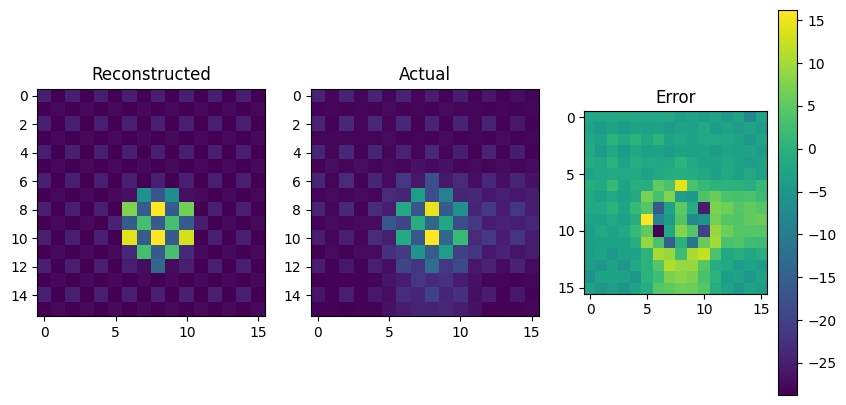

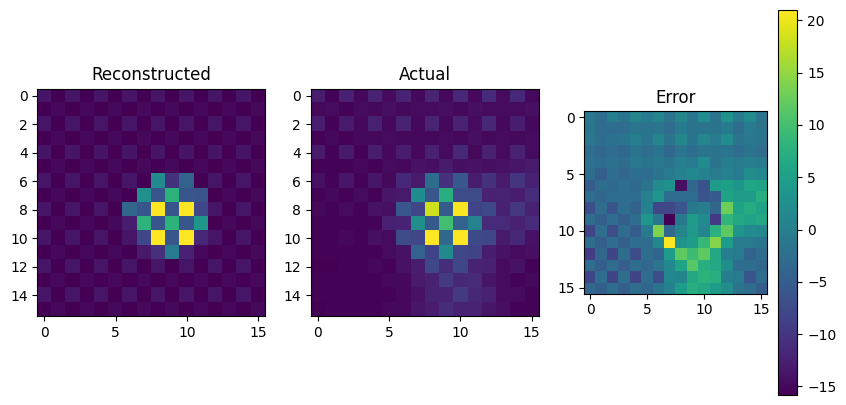

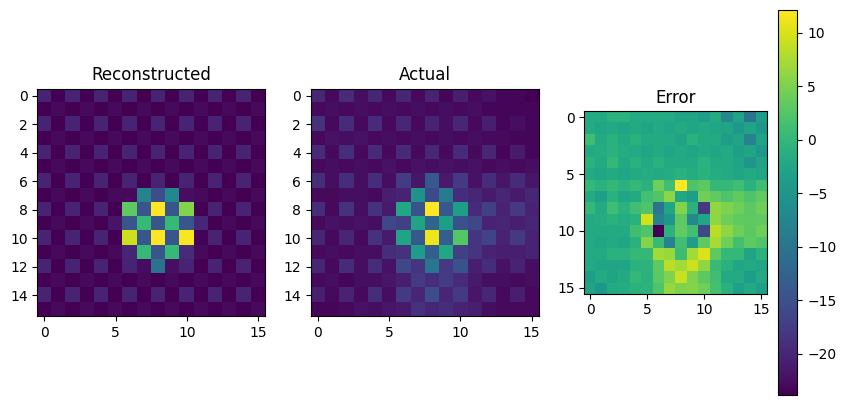

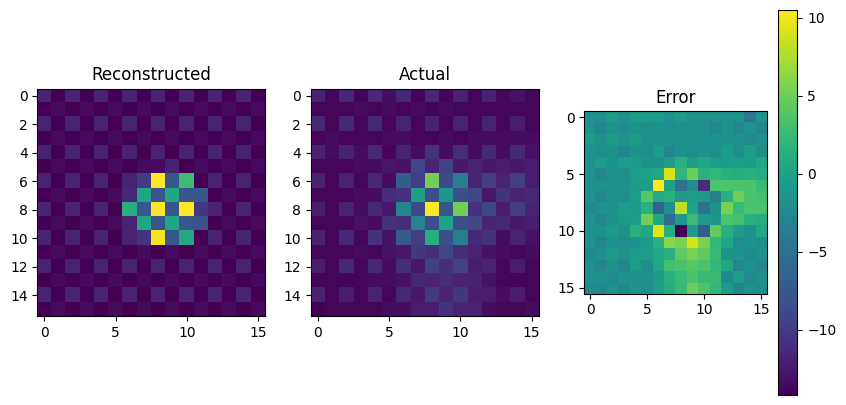

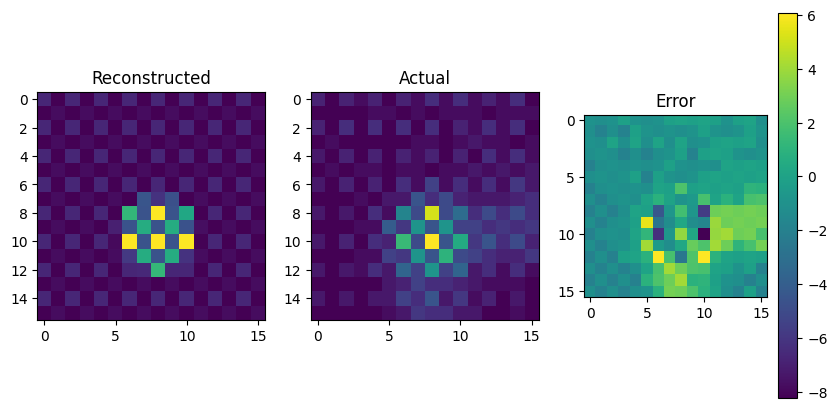

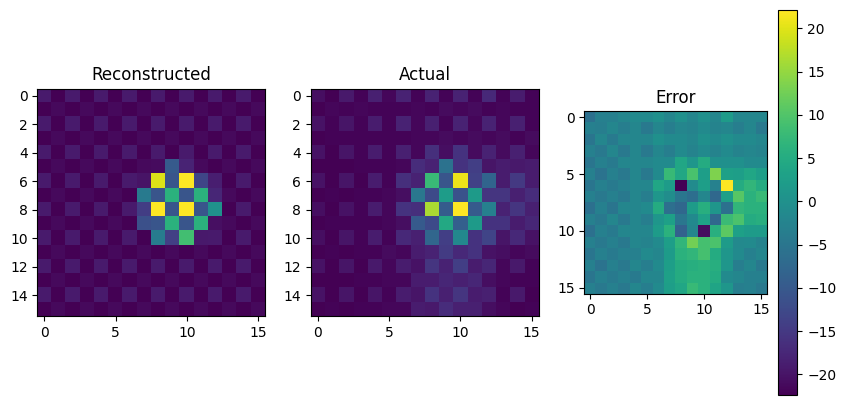

In [149]:
tag0HessInv = []
tag0Predictions = []

for i in range(onlyTag0.shape[0]):
    realImg = getSnipPlot(onlyTag0['Tag'].iloc[i])
    params = np.array([8.0, 8, 100, 50, 20, 5, 4, 3])
    res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
                bounds=((0,16), (0,16), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None)))
    tagCoord, tagBright, bgBright = res.x[:2], res.x[2:5], res.x[5:]
    pred = np.array(simulate_image(tagCoord, tagBright, bgBright, 2.6, [16,16])).reshape([16,16])
    tag0HessInv.append(hessian(temp)(res.x))
    tag0Predictions.append(pred)
    
    plt.figure(figsize=[10,5])
    plt.subplot(1,3,1)
    plt.imshow(pred)
    plt.title("Reconstructed")
    plt.subplot(1,3,2)
    plt.imshow(realImg)
    plt.title("Actual")
    plt.subplot(1,3,3)
    plt.imshow(np.array(realImg - pred))
    plt.colorbar()
    plt.title("Error")

C:\Users\katie\AppData\Local\Temp\ipykernel_8728\3996828078.py:6: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
C:\Users\katie\AppData\Local\Temp\ipykernel_8728\3996828078.py:6: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
C:\Users\katie\AppData\Local\Temp\ipykernel_8728\3996828078.py:6: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
C:\Users\katie\AppData\Local\Temp\ipykernel_8728\3996828078.py:6: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
C:\Users\katie\AppData\Local\Temp\ipykernel_8728\3996828078.py:6: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(temp, params, jac=gr

,Tag,Reconstruction
0,0,"[11.719773, 4.63464, 11.719773, 4.63464, 11.71..."
1,1,"[16.931143, 11.9008465, 16.931143, 11.9008465,..."
2,2,"[7.7461667, 5.206488, 7.7461667, 5.206488, 7.7..."
3,3,"[4.39972, 3.3331609, 4.39972, 3.3331609, 4.399..."
4,4,"[4.016769, 3.6350334, 4.016769, 3.6350334, 4.0..."
...,...,...
75,35,"[7.6603236, 8.31445, 7.6603236, 8.31445, 7.660..."
76,36,"[7.535541, 7.5165167, 7.535541, 7.5165167, 7.5..."
77,37,"[8.348968, 5.7374983, 8.348968, 5.7374983, 8.3..."
78,38,"[6.8195744, 5.822143, 6.8195744, 5.822143, 6.8..."


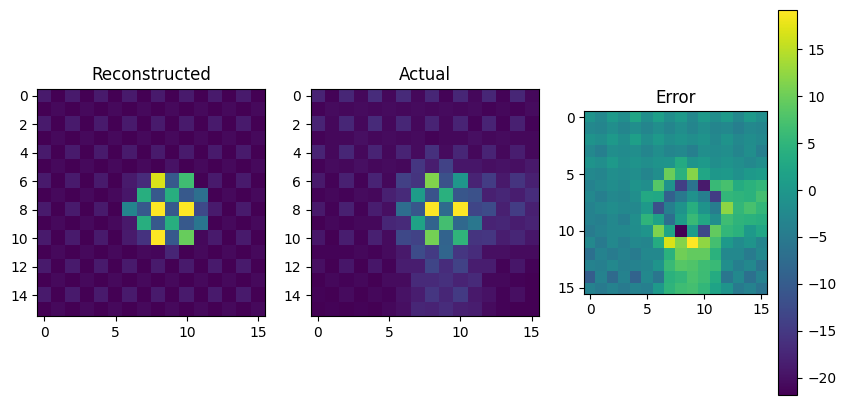

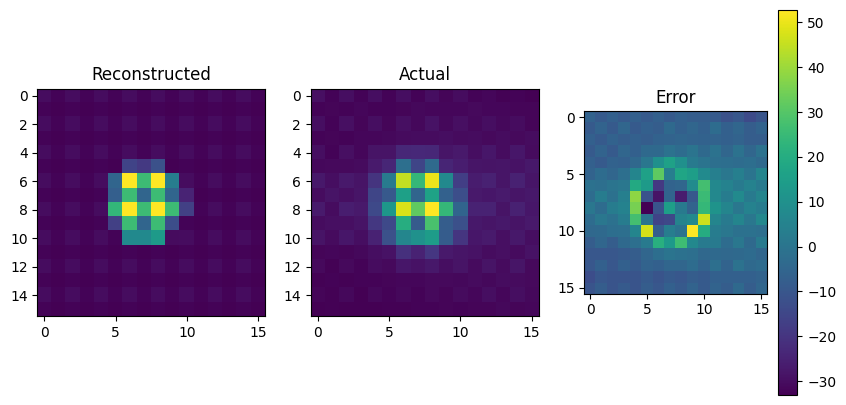

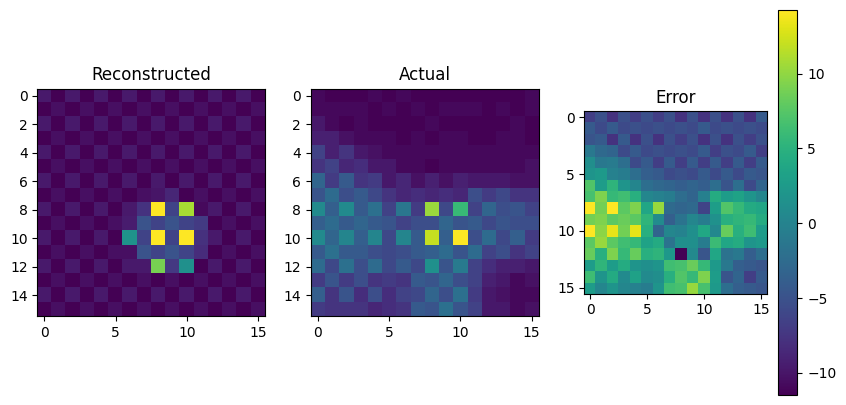

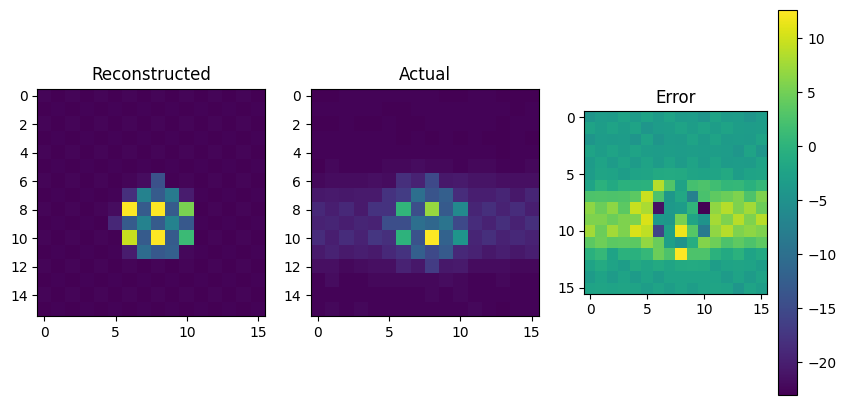

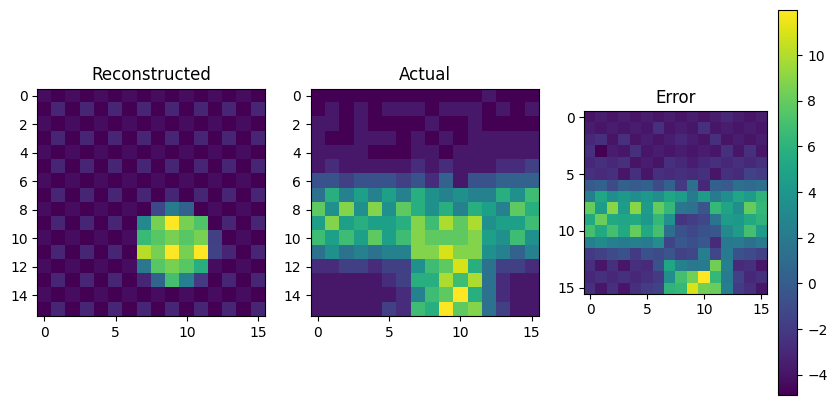

In [113]:
allTagPredictions = pd.DataFrame(columns=['Tag', 'Reconstruction'])

for i in range(80):
    realImg = getSnipPlot(allTags['Tag'].iloc[i])
    params = np.array([8.0, 8, 100, 50, 20, 5, 4, 3])
    res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
                bounds=((0,16), (0,16), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None)))
    tagCoord, tagBright, bgBright = res.x[:2], res.x[2:5], res.x[5:]
    p = np.array(simulate_image(tagCoord, tagBright, bgBright, 2.6, [16,16]))
    pred = p.reshape([16,16])
    allTagPredictions.loc[i] = [allTags['Label'].iloc[i], p]

    if i < 5:
        plt.figure(figsize=[10,5])
        plt.subplot(1,3,1)
        plt.imshow(pred)
        plt.title("Reconstructed")
        plt.subplot(1,3,2)
        plt.imshow(realImg)
        plt.title("Actual")
        plt.subplot(1,3,3)
        plt.imshow(np.array(realImg - pred))
        plt.colorbar()
        plt.title("Error")
allTagPredictions

In [102]:
# Extension -> split error by colour channel
#     redGuess, red = getOnlyColour('R', pred, realImg)
#     greenGuess, green = getOnlyColour('G', pred, realImg)
#     blueGuess, blue = getOnlyColour('B', pred, realImg)
    
#     plt.figure(figsize=[10,5])
#     plt.subplot(1,4,1)
#     error = np.array(red -redGuess)
#     plt.imshow(error, clim=[-25,25])
#     plt.colorbar()
#     plt.subplot(1,4,2)
#     error = np.array(green - greenGuess)
#     plt.imshow(error, clim=[-25,25])
#     plt.colorbar()
#     plt.subplot(1,4,3)
#     error = np.array(blue - blueGuess)
#     plt.imshow(error, clim=[-25,25])
#     plt.colorbar()
#     plt.subplot(1,4,4)
#     error = np.array(realImg)
#     plt.imshow(error, clim=[0,255])
#     plt.colorbar()

In [153]:
# Inverse Hessian can be used as covariance of the Gaussian
covA = np.linalg.inv(tag0HessInv[0])
covB = np.linalg.inv(tag0HessInv[1])

# Maximum-likelihood estimation gives the mean of the Gaussian
# meanA = np.matrix.mean(hessA)
# meanB = np.matrix.mean(hessB)

# x = np.random.multivariate_normal(meanA, covA, 1000)
# plt.scatter(x[:, 0], x[:, 1], 1, color='b')
# x = np.random.multivariate_normal(meanB, covB, 1000)
# plt.scatter(x[:,0], x[:, 1], 1, color='g')

# covC = np.linalg.inv(np.linalg.inv(covA) + np.linalg.inv(covB))
# meanC = covC @ ((np.linalg.inv(covA) @ meanA + np.linalg.inv(covB) @ meanB))
# x = np.random.multivariate_normal(meanC,covC,1000)
# plt.scatter(x[:,0],x[:,1],1,color='black')

### Plot colours - original vs resconstructed

In [154]:
label = [i+1 for i in range(onlyTag0.shape[0])]
label2 = [(i*10) for i in label]

In [155]:
tag0PredColours = []
for pred in tag0Predictions:
    r, g, b = getPixels((0, 16, 0, 16), pred)
    tag0PredColours.append([r, g, b])

In [157]:
def plotHeatmap2(asTuples, asTuples2, labels, labels2, scale):
    data = generateHeatmapData(scale)
    plt.figure(figsize=[12,10])
    ax = plt.gca()
    _, tax = ternary.figure(ax,scale=scale)

    tax.scatter(asTuples*scale, marker='x', color='#fff', label=labels, zorder=3)
    tax._redraw_labels()
    tax.scatter(asTuples2*scale, marker='x', color='#000', label=labels, zorder=3)
    tax._redraw_labels()
    tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False)
    tax._redraw_labels()
    # Remove default Matplotlib Axes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    tax.boundary()
    tax.set_title("RGBA Heatmap")
    for a, b in zip(labels, asTuples):
        tax.annotate(int(a), b, color='white')
    for a, b in zip(labels2, asTuples2):
        tax.annotate(int(a), b, color='black')
    plt.show()

C:\Users\katie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


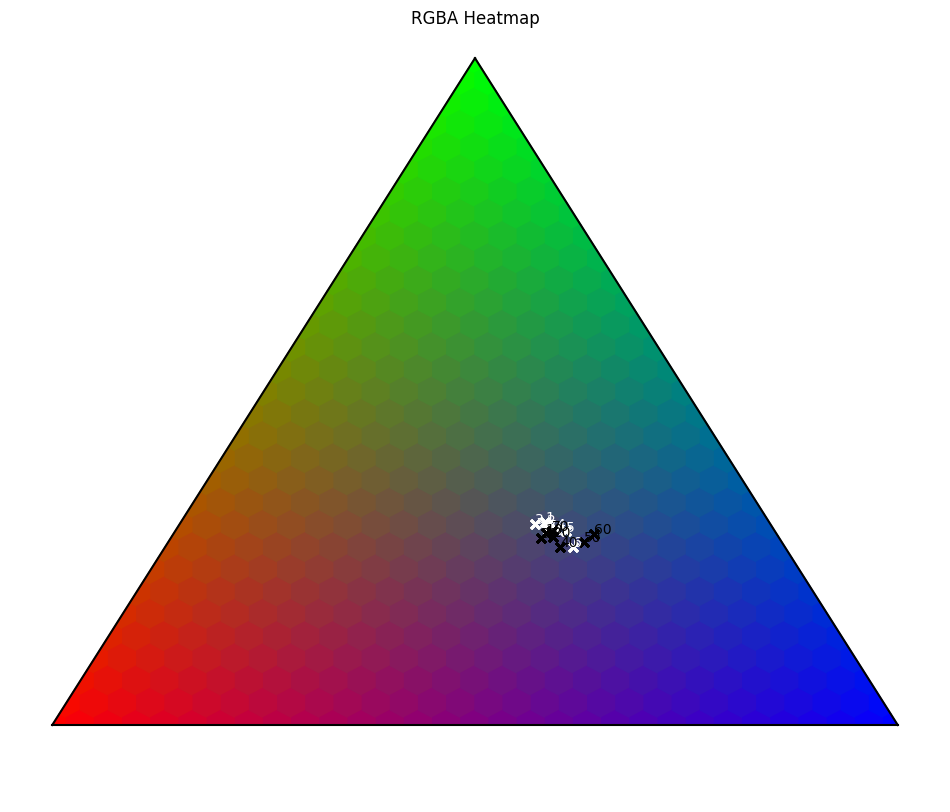

In [158]:
originalTuple = [[x['Red']*scale, x['Green']*scale, x['Blue']*scale] for index, x in onlyTag0.iterrows()]
predTuple = [[y[0]*scale, y[1]*scale, y[2]*scale] for y in tag0PredColours]
plotHeatmap2(originalTuple, predTuple, label, label2, scale)

C:\Users\katie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


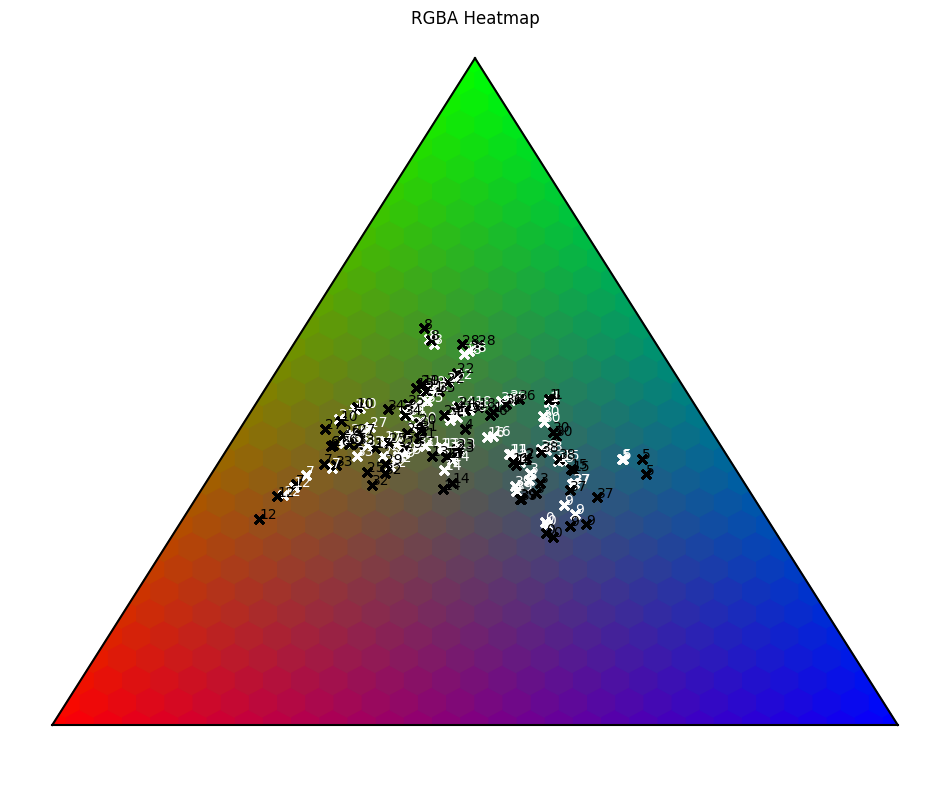

In [142]:
tagPredColours = []
for p in allTagPredictions['Reconstruction']:
    pred = np.array(p).reshape((16,16))
    r, g, b = getPixels((0, 16, 0, 16), pred)
    tagPredColours.append([r, g, b])

labelV1 = [i for i in allTags['Label'].iloc[:80]]
labelV2 = [i for i in allTagPredictions['Tag']]

originalTuple1 = [[x['Red']*scale, x['Green']*scale, x['Blue']*scale] for index, x in allTags.iloc[:80].iterrows()]
predTuple1 = [[y[0]*scale, y[1]*scale, y[2]*scale] for y in tagPredColours]
plotHeatmap2(originalTuple1, predTuple1, labelV1, labelV2, scale)

Text(0.5, 1.0, 'Plot of 1 tag (in 7 images) in Hue and Saturation')

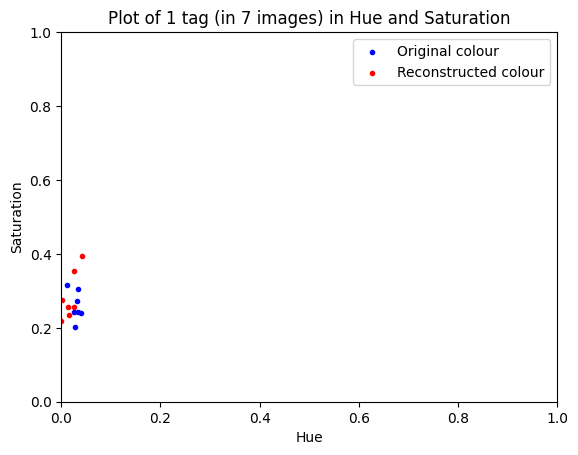

In [160]:
import colorsys
# is luminence relevant? plot as hue + saturation pairs
originalHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(x['Red'], x['Green'], x['Blue']) for index, x in onlyTag0.iterrows()]])
predHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in tag0PredColours]])

ax = plt.axes()
plt.scatter(originalHS[:, 0], originalHS[:, 1], c='b', marker='.', label='Original colour')
plt.scatter(predHS[:, 0], predHS[:, 1], c='r', marker='.', label='Reconstructed colour')
ax.set(xlim=(0, 1.0), ylim=(0, 1.0))
plt.legend()
plt.xlabel('Hue')
plt.ylabel('Saturation')
plt.title(label='Plot of 1 tag (in 7 images) in Hue and Saturation')

Text(0.5, 1.0, 'Plot of 80 tags (2 of each) in Hue and Saturation')

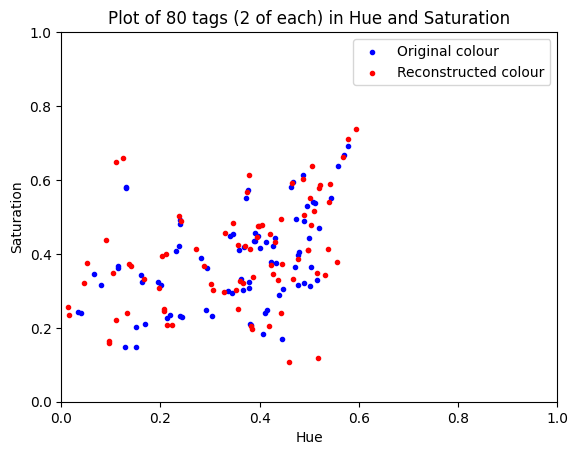

In [ ]:
moreOriginalHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(x['Red'], x['Green'], x['Blue']) for index, x in allTags.iloc[:80].iterrows()]])
morePredHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in tagPredColours]])

ax = plt.axes()
plt.scatter(moreOriginalHS[:, 0], moreOriginalHS[:, 1], c='b', marker='.', label='Original colour')
plt.scatter(morePredHS[:, 0], morePredHS[:, 1], c='r', marker='.', label='Reconstructed colour')
ax.set(xlim=(0, 1.0), ylim=(0, 1.0))
plt.legend()
plt.xlabel('Hue')
plt.ylabel('Saturation')
plt.title(label='Plot of 80 tags (2 of each) in Hue and Saturation')

# Notes/to do

In [110]:
# plot different widths and compare errors - find best width
    # mean square error over all tags results: 2.5 = 271, 2.6 = 0, 2.7 = 0, 2.8 = 9
    # 2.5 best width?
    # possible to optimise tag width as part of cost function
    # is circle best sizing - circle function not accurate at small sizes - try square with corners cut off?
# substract to find errors
    # specific place(edge) / colour
# airy disk pretty visible - possible ot fit to tags optimising?
    # airy disk - why it happens - simulate shape
# may need differing calculations for each camera set up

# plot as HLS not RGB!!!
# try optimise for new tag pics
# get sd of new pictures

# compare single tag predictions across multiple images
# samples from hessian plot on colour triangle - same tag of diff pictures - do blobs of uncertainty overlap? mulitply and normalise - new gaussian scaled
    # see matrix cookbook for equations
    # combine uncertainties of same tag on 2 images - should combine to assist identification

# leave out a tag - can it fit it to the right blob?